# Neural network for classification of contaminants with MAT

## 1. Formulate/outline the problem: classification

Simple neural network for classification of the contaminants using MAT transcriptomes


In [25]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [26]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import wandb
import tensorflow as tf
from tensorflow import keras

In [27]:
file_name = "gene_counts_NN_training.csv"

In [28]:
data = pd.read_csv(file_name)

## 2. Identify inputs and outputs

In [29]:
data["sample"].value_counts()

sample
R848       5
CRX-527    5
CL-307     5
Pam3       5
LPS        5
PGN        5
IMDM       5
Fla-PA     3
LTA        3
Name: count, dtype: int64

## 3. Prepare data

In [30]:
data_features = data.drop(columns=["sample"])
target = data["sample"]

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_features, target, test_size=0.2, random_state=0, shuffle=True, stratify=target
)

In [32]:
y_train.value_counts(), y_test.value_counts()

(sample
 Pam3       4
 R848       4
 IMDM       4
 PGN        4
 LPS        4
 CRX-527    4
 CL-307     4
 Fla-PA     2
 LTA        2
 Name: count, dtype: int64,
 sample
 Pam3       1
 R848       1
 Fla-PA     1
 CRX-527    1
 LPS        1
 LTA        1
 IMDM       1
 PGN        1
 CL-307     1
 Name: count, dtype: int64)

In [33]:
def to_normalize_DESeq2_style(data):
    # Ensure all values are non-negative
    data = data.applymap(lambda x: max(x, 0))

    # Take the log
    log_data = np.log1p(data)

    # Calculate the pseudo-reference sample for each gene
    log_data["pseudo_reference"] = log_data.mean(axis=1)

    # Filter out genes with -Inf as their average
    filtered_log_data = log_data[log_data["pseudo_reference"] != float("-inf")]

    # Subtract the gene pseudo-references from log counts
    ratio_data = filtered_log_data.iloc[:, :-1].sub(
        filtered_log_data["pseudo_reference"], axis=0
    )

    # Find the median of the ratios for each sample
    sample_medians = ratio_data.median(axis=0)

    # Convert medians to scaling factors
    scaling_factors = np.exp(sample_medians)

    # Divide the original counts by the scaling factors
    manually_normalized = data.div(scaling_factors)

    return manually_normalized


X_train = to_normalize_DESeq2_style(X_train)

X_test = to_normalize_DESeq2_style(X_test)

In [34]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
encoded_labels = le.transform(y_train)
le_name_mapping = dict(zip(le.classes_, encoded_labels))

In [35]:
le_name_mapping

{'CL-307': 7,
 'CRX-527': 8,
 'Fla-PA': 3,
 'IMDM': 6,
 'LPS': 7,
 'LTA': 4,
 'PGN': 1,
 'Pam3': 3,
 'R848': 4}

In [36]:
from sklearn.feature_selection import chi2, SelectKBest

# Define feature selection
fs = SelectKBest(score_func=chi2, k=500)

# Apply feature selection
X_train = fs.fit_transform(X_train, encoded_labels)

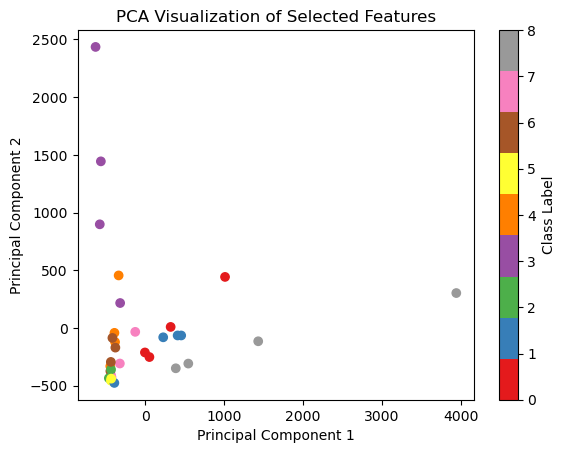

In [37]:
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)

# Scatter plot
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=encoded_labels, cmap="Set1")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Selected Features")
plt.colorbar(label="Class Label")
plt.show()

In [38]:
# Transform the test feature matrix
X_test = fs.transform(X_test)

In [39]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

## 4. Build an architecture from scratch or choose a pretrained model

In [52]:
keras.backend.clear_session()
keras.utils.set_random_seed(2)

In [53]:
WANDB_NOTEBOOK_NAME = "20230829 NN first sweep"

In [54]:
sweep_config = {
    "method": "bayes",
    "name": "third_sweep",
    "metric": {
        "name": "Validation AUC",
        "goal": "maximize",
    },
    "parameters": {
        "l1": {"values": [16, 24, 32, 40]},
        "l2": {"values": [16, 24, 32, 40]},
        "epochs": {"values": [200, 280, 320]},
        "learning_rate": {"distribution": "uniform", "min": 0.008, "max": 0.02},
        "batch_size": {"values": [12]},
        "weights_limit": {"distribution": "uniform", "min": 0.008, "max": 0.02},
        "dropout_rates": {"values": [0.2, 0.3, 0.4]},
    },
}

In [55]:
sweep_id = wandb.sweep(sweep=sweep_config, project="NN-MATseq")

Create sweep with ID: di7m6sga
Sweep URL: https://wandb.ai/afanasyeva-team/NN-MATseq/sweeps/di7m6sga


In [56]:
default_config = {
    "l1": 32,
    "l2": 32,
    "dropout_rates": 0.3,
    "batch_size": 12,
    "activation": "relu",
    "weights_limit": 0.0114,
    "epochs": 280,
    "learning_rate": 0.0156,
    "loss": "categorical_crossentropy",
    "optimizer": "adam",
}

In [57]:
earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, verbose=0, mode="min", restore_best_weights=True
)

In [58]:
from wandb.keras import WandbCallback


def train():
    with wandb.init(project="NN-MATseq", config=default_config) as run:
        dropout_rates = run.config.dropout_rates
        batch_size = run.config.batch_size
        activation = run.config.activation
        weights_limit = run.config.weights_limit
        epochs = run.config.epochs
        learning_rate = run.config.learning_rate
        loss = run.config.loss
        l1 = run.config.l1
        l2 = run.config.l2

        if run.config.optimizer == "adam":
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        elif run.config.optimizer == "sgd":
            optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
        elif run.config.optimizer == "rmsprop":
            optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

        inputs = keras.Input(shape=X_train.shape[1])
        x = keras.layers.UnitNormalization()(inputs)

        x = keras.layers.Dense(
            l1,
            activation=activation,
            kernel_regularizer=keras.regularizers.L2(weights_limit),
        )(x)
        x = keras.layers.Dropout(dropout_rates)(x)

        x = keras.layers.Dense(
            l2,
            activation=activation,
            kernel_regularizer=keras.regularizers.L2(weights_limit),
        )(x)
        x = keras.layers.Dropout(dropout_rates)(x)

        outputs = keras.layers.Dense(9, activation="softmax")(x)

        model = keras.Model(
            inputs=inputs, outputs=outputs, name="NN_multiclass_classifier_MATseq"
        )

        model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[
                "accuracy",
                keras.metrics.AUC(name="auc"),
            ],
        )

        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            verbose=True,
        )

        model.save("NN_multiclass_classifier_MATseq.keras", overwrite=True)

        wandb.log({"AUC": history.history["auc"][-1]})
        wandb.log({"Validation AUC": history.history["val_auc"][-1]})
        wandb.log({"Loss": history.history["loss"][-1]})
        wandb.log({"Validation Loss": history.history["val_loss"][-1]})
        wandb.log({"Accuracy": history.history["accuracy"][-1]})
        wandb.log({"Validation Accuracy": history.history["val_accuracy"][-1]})

In [59]:
count = 50
wandb.agent(sweep_id, train, count=count)

wandb: Agent Starting Run: hfkda4sd with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 320
wandb: 	l1: 24
wandb: 	l2: 40
wandb: 	learning_rate: 0.01951288241426278
wandb: 	weights_limit: 0.016091196700232832
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 106ms/step - loss: 3.1425 - accuracy: 0.0938 - auc: 0.4645 - val_loss: 2.6072 - val_accuracy: 0.1111 - val_auc: 0.5656
Epoch 2/320
3/3 [==============================] - 0s 22ms/step - loss: 2.4989 - accuracy: 0.2188 - auc: 0.6091 - val_loss: 2.3829 - val_accuracy: 0.2222 - val_auc: 0.6327
Epoch 3/320
3/3 [==============================] - 0s 21ms/step - loss: 2.3419 - accuracy: 0.3438 - auc: 0.6787 - val_loss: 2.3385 - val_accuracy: 0.2222 - val_auc: 0.6466
Epoch 4/320
3/3 [==============================] - 0s 21ms/step - loss: 2.2317 - accuracy: 0.2812 - auc: 0.7377 - val_loss: 2.2873 - val_accuracy: 0.2222 - val_auc: 0.6458
Epoch 5/320
3/3 [==============================] - 0s 20ms/step - loss: 2.1221 - accuracy: 0.2500 - auc: 0.7618 - val_loss: 2.1798 - val_accuracy: 0.2222 - val_auc: 0.7269
Epoch 6/320
3/3 [==============================] - 0s 21ms/step - loss: 2.0044 - accuracy: 0.2188 - auc: 0.8135 - val_loss: 2.0505 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.979
Accuracy,0.75
Loss,1.07735
Validation AUC,0.98611
Validation Accuracy,0.77778


wandb: Agent Starting Run: ung9gb0q with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 320
wandb: 	l1: 40
wandb: 	l2: 32
wandb: 	learning_rate: 0.01586245474247709
wandb: 	weights_limit: 0.017448025923836756
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 100ms/step - loss: 3.7304 - accuracy: 0.0625 - auc: 0.4977 - val_loss: 2.9764 - val_accuracy: 0.2222 - val_auc: 0.5509
Epoch 2/320
3/3 [==============================] - 0s 23ms/step - loss: 2.8349 - accuracy: 0.1250 - auc: 0.5601 - val_loss: 2.5610 - val_accuracy: 0.2222 - val_auc: 0.6343
Epoch 3/320
3/3 [==============================] - 0s 21ms/step - loss: 2.5193 - accuracy: 0.1562 - auc: 0.6440 - val_loss: 2.4759 - val_accuracy: 0.2222 - val_auc: 0.6466
Epoch 4/320
3/3 [==============================] - 0s 21ms/step - loss: 2.4508 - accuracy: 0.2188 - auc: 0.6866 - val_loss: 2.4209 - val_accuracy: 0.3333 - val_auc: 0.6867
Epoch 5/320
3/3 [==============================] - 0s 22ms/step - loss: 2.3340 - accuracy: 0.2812 - auc: 0.7426 - val_loss: 2.3431 - val_accuracy: 0.2222 - val_auc: 0.7037
Epoch 6/320
3/3 [==============================] - 0s 21ms/step - loss: 2.2308 - accuracy: 0.2188 - auc: 0.7455 - val_loss: 2.2463 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.94226
Accuracy,0.65625
Loss,1.502
Validation AUC,0.96836
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dh8h6k8c with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 320
wandb: 	l1: 40
wandb: 	l2: 24
wandb: 	learning_rate: 0.01665311026636001
wandb: 	weights_limit: 0.01908308418405629
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 99ms/step - loss: 3.7440 - accuracy: 0.0938 - auc: 0.5505 - val_loss: 2.9289 - val_accuracy: 0.3333 - val_auc: 0.5748
Epoch 2/320
3/3 [==============================] - 0s 21ms/step - loss: 2.7772 - accuracy: 0.2500 - auc: 0.5987 - val_loss: 2.5665 - val_accuracy: 0.3333 - val_auc: 0.6181
Epoch 3/320
3/3 [==============================] - 0s 20ms/step - loss: 2.4585 - accuracy: 0.2500 - auc: 0.7075 - val_loss: 2.5242 - val_accuracy: 0.3333 - val_auc: 0.6427
Epoch 4/320
3/3 [==============================] - 0s 21ms/step - loss: 2.4699 - accuracy: 0.3438 - auc: 0.6741 - val_loss: 2.4676 - val_accuracy: 0.3333 - val_auc: 0.6968
Epoch 5/320
3/3 [==============================] - 0s 20ms/step - loss: 2.2970 - accuracy: 0.3125 - auc: 0.7756 - val_loss: 2.3687 - val_accuracy: 0.3333 - val_auc: 0.7423
Epoch 6/320
3/3 [==============================] - 0s 20ms/step - loss: 2.2577 - accuracy: 0.2812 - auc: 0.7595 - val_loss: 2.2773 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.97607
Accuracy,0.71875
Loss,1.19544
Validation AUC,0.98148
Validation Accuracy,0.66667


wandb: Agent Starting Run: hnb7yzyz with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 40
wandb: 	learning_rate: 0.014539893690452796
wandb: 	weights_limit: 0.017351844635193785
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 100ms/step - loss: 3.5351 - accuracy: 0.0000e+00 - auc: 0.4426 - val_loss: 2.8822 - val_accuracy: 0.1111 - val_auc: 0.5941
Epoch 2/280
3/3 [==============================] - 0s 21ms/step - loss: 2.7258 - accuracy: 0.1250 - auc: 0.6429 - val_loss: 2.4972 - val_accuracy: 0.3333 - val_auc: 0.6651
Epoch 3/280
3/3 [==============================] - 0s 22ms/step - loss: 2.4210 - accuracy: 0.2812 - auc: 0.7195 - val_loss: 2.3902 - val_accuracy: 0.2222 - val_auc: 0.7014
Epoch 4/280
3/3 [==============================] - 0s 20ms/step - loss: 2.2389 - accuracy: 0.3750 - auc: 0.8076 - val_loss: 2.3557 - val_accuracy: 0.3333 - val_auc: 0.7346
Epoch 5/280
3/3 [==============================] - 0s 21ms/step - loss: 2.2457 - accuracy: 0.3750 - auc: 0.7753 - val_loss: 2.2656 - val_accuracy: 0.3333 - val_auc: 0.7346
Epoch 6/280
3/3 [==============================] - 0s 21ms/step - loss: 2.1057 - accuracy: 0.3438 - auc: 0.7993 - val_loss: 2.1442 - va

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.995
Accuracy,0.84375
Loss,0.79836
Validation AUC,0.94367
Validation Accuracy,0.77778


wandb: Agent Starting Run: 7vkf3hl6 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 320
wandb: 	l1: 24
wandb: 	l2: 40
wandb: 	learning_rate: 0.016933162091827207
wandb: 	weights_limit: 0.01288228852162262
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 103ms/step - loss: 3.0065 - accuracy: 0.0938 - auc: 0.4835 - val_loss: 2.6249 - val_accuracy: 0.1111 - val_auc: 0.5656
Epoch 2/320
3/3 [==============================] - 0s 22ms/step - loss: 2.5313 - accuracy: 0.1875 - auc: 0.5923 - val_loss: 2.3956 - val_accuracy: 0.2222 - val_auc: 0.6358
Epoch 3/320
3/3 [==============================] - 0s 21ms/step - loss: 2.3346 - accuracy: 0.2500 - auc: 0.6620 - val_loss: 2.3189 - val_accuracy: 0.3333 - val_auc: 0.6551
Epoch 4/320
3/3 [==============================] - 0s 20ms/step - loss: 2.2302 - accuracy: 0.3750 - auc: 0.7506 - val_loss: 2.2790 - val_accuracy: 0.4444 - val_auc: 0.7130
Epoch 5/320
3/3 [==============================] - 0s 20ms/step - loss: 2.1418 - accuracy: 0.2812 - auc: 0.7781 - val_loss: 2.2232 - val_accuracy: 0.5556 - val_auc: 0.7708
Epoch 6/320
3/3 [==============================] - 0s 21ms/step - loss: 2.0923 - accuracy: 0.3438 - auc: 0.7675 - val_loss: 2.1718 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98816
Accuracy,0.84375
Loss,0.95983
Validation AUC,0.90972
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7qefd5ln with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 320
wandb: 	l1: 32
wandb: 	l2: 40
wandb: 	learning_rate: 0.016939286895370304
wandb: 	weights_limit: 0.01809237407976814
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 101ms/step - loss: 3.5333 - accuracy: 0.0625 - auc: 0.4932 - val_loss: 2.7932 - val_accuracy: 0.2222 - val_auc: 0.6543
Epoch 2/320
3/3 [==============================] - 0s 22ms/step - loss: 2.6591 - accuracy: 0.2500 - auc: 0.6462 - val_loss: 2.4520 - val_accuracy: 0.3333 - val_auc: 0.6821
Epoch 3/320
3/3 [==============================] - 0s 20ms/step - loss: 2.4038 - accuracy: 0.3438 - auc: 0.6928 - val_loss: 2.3884 - val_accuracy: 0.2222 - val_auc: 0.6481
Epoch 4/320
3/3 [==============================] - 0s 21ms/step - loss: 2.2988 - accuracy: 0.3125 - auc: 0.7365 - val_loss: 2.3188 - val_accuracy: 0.3333 - val_auc: 0.7461
Epoch 5/320
3/3 [==============================] - 0s 22ms/step - loss: 2.1925 - accuracy: 0.2812 - auc: 0.7983 - val_loss: 2.2016 - val_accuracy: 0.2222 - val_auc: 0.7446
Epoch 6/320
3/3 [==============================] - 0s 21ms/step - loss: 2.0605 - accuracy: 0.3750 - auc: 0.8101 - val_loss: 2.1190 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.97748
Accuracy,0.75
Loss,1.16505
Validation AUC,0.94059
Validation Accuracy,0.66667


wandb: Agent Starting Run: dugrjck1 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 320
wandb: 	l1: 40
wandb: 	l2: 24
wandb: 	learning_rate: 0.016800287626796546
wandb: 	weights_limit: 0.014717504789734426
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 99ms/step - loss: 3.4693 - accuracy: 0.0938 - auc: 0.4294 - val_loss: 2.8300 - val_accuracy: 0.3333 - val_auc: 0.5864
Epoch 2/320
3/3 [==============================] - 0s 21ms/step - loss: 2.6830 - accuracy: 0.1562 - auc: 0.6185 - val_loss: 2.4911 - val_accuracy: 0.3333 - val_auc: 0.6335
Epoch 3/320
3/3 [==============================] - 0s 22ms/step - loss: 2.4894 - accuracy: 0.1562 - auc: 0.5964 - val_loss: 2.4148 - val_accuracy: 0.4444 - val_auc: 0.6574
Epoch 4/320
3/3 [==============================] - 0s 20ms/step - loss: 2.3305 - accuracy: 0.1875 - auc: 0.7180 - val_loss: 2.3764 - val_accuracy: 0.3333 - val_auc: 0.6836
Epoch 5/320
3/3 [==============================] - 0s 21ms/step - loss: 2.2605 - accuracy: 0.3750 - auc: 0.7538 - val_loss: 2.2722 - val_accuracy: 0.3333 - val_auc: 0.7122
Epoch 6/320
3/3 [==============================] - 0s 21ms/step - loss: 2.1533 - accuracy: 0.2500 - auc: 0.7620 - val_loss: 2.2065 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.93353
Accuracy,0.65625
Loss,1.52885
Validation AUC,0.99074
Validation Accuracy,0.88889


wandb: Agent Starting Run: 5j3hgt9g with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 280
wandb: 	l1: 40
wandb: 	l2: 24
wandb: 	learning_rate: 0.018269854747821737
wandb: 	weights_limit: 0.01875430601689416
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 100ms/step - loss: 3.6907 - accuracy: 0.0938 - auc: 0.5529 - val_loss: 2.8900 - val_accuracy: 0.1111 - val_auc: 0.5432
Epoch 2/280
3/3 [==============================] - 0s 21ms/step - loss: 2.7690 - accuracy: 0.1562 - auc: 0.5264 - val_loss: 2.5511 - val_accuracy: 0.2222 - val_auc: 0.6157
Epoch 3/280
3/3 [==============================] - 0s 21ms/step - loss: 2.5299 - accuracy: 0.1875 - auc: 0.6017 - val_loss: 2.5163 - val_accuracy: 0.1111 - val_auc: 0.6721
Epoch 4/280
3/3 [==============================] - 0s 21ms/step - loss: 2.4619 - accuracy: 0.3438 - auc: 0.6725 - val_loss: 2.4634 - val_accuracy: 0.2222 - val_auc: 0.6443
Epoch 5/280
3/3 [==============================] - 0s 21ms/step - loss: 2.4191 - accuracy: 0.1250 - auc: 0.6104 - val_loss: 2.3637 - val_accuracy: 0.2222 - val_auc: 0.6721
Epoch 6/280
3/3 [==============================] - 0s 21ms/step - loss: 2.3374 - accuracy: 0.1562 - auc: 0.6319 - val_loss: 2.2973 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.94653
Accuracy,0.59375
Loss,1.3576
Validation AUC,0.97531
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dvzxqm2w with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 320
wandb: 	l1: 40
wandb: 	l2: 16
wandb: 	learning_rate: 0.014709480757583774
wandb: 	weights_limit: 0.015384572518572491
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 101ms/step - loss: 3.4038 - accuracy: 0.1875 - auc: 0.4814 - val_loss: 2.8108 - val_accuracy: 0.1111 - val_auc: 0.6057
Epoch 2/320
3/3 [==============================] - 0s 22ms/step - loss: 2.6511 - accuracy: 0.2812 - auc: 0.6275 - val_loss: 2.5192 - val_accuracy: 0.1111 - val_auc: 0.5941
Epoch 3/320
3/3 [==============================] - 0s 25ms/step - loss: 2.3813 - accuracy: 0.3438 - auc: 0.6948 - val_loss: 2.4361 - val_accuracy: 0.2222 - val_auc: 0.6381
Epoch 4/320
3/3 [==============================] - 0s 23ms/step - loss: 2.4305 - accuracy: 0.0938 - auc: 0.6399 - val_loss: 2.3706 - val_accuracy: 0.2222 - val_auc: 0.6829
Epoch 5/320
3/3 [==============================] - 0s 22ms/step - loss: 2.2696 - accuracy: 0.1250 - auc: 0.7545 - val_loss: 2.3176 - val_accuracy: 0.3333 - val_auc: 0.7137
Epoch 6/320
3/3 [==============================] - 0s 21ms/step - loss: 2.3081 - accuracy: 0.1875 - auc: 0.7109 - val_loss: 2.2462 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98065
Accuracy,0.84375
Loss,1.13169
Validation AUC,0.95679
Validation Accuracy,0.77778


wandb: Agent Starting Run: t9tvtbgn with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 320
wandb: 	l1: 40
wandb: 	l2: 24
wandb: 	learning_rate: 0.0174601688261392
wandb: 	weights_limit: 0.0169026270197453
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 99ms/step - loss: 3.5911 - accuracy: 0.0312 - auc: 0.4830 - val_loss: 2.8353 - val_accuracy: 0.1111 - val_auc: 0.6003
Epoch 2/320
3/3 [==============================] - 0s 21ms/step - loss: 2.6535 - accuracy: 0.1562 - auc: 0.6296 - val_loss: 2.5205 - val_accuracy: 0.1111 - val_auc: 0.6258
Epoch 3/320
3/3 [==============================] - 0s 21ms/step - loss: 2.4852 - accuracy: 0.1250 - auc: 0.6092 - val_loss: 2.4813 - val_accuracy: 0.2222 - val_auc: 0.6682
Epoch 4/320
3/3 [==============================] - 0s 21ms/step - loss: 2.4085 - accuracy: 0.1562 - auc: 0.6880 - val_loss: 2.4200 - val_accuracy: 0.2222 - val_auc: 0.6952
Epoch 5/320
3/3 [==============================] - 0s 21ms/step - loss: 2.2912 - accuracy: 0.2500 - auc: 0.7296 - val_loss: 2.3176 - val_accuracy: 0.2222 - val_auc: 0.7168
Epoch 6/320
3/3 [==============================] - 0s 21ms/step - loss: 2.2473 - accuracy: 0.1562 - auc: 0.6992 - val_loss: 2.2368 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.95465
Accuracy,0.65625
Loss,1.34009
Validation AUC,0.95679
Validation Accuracy,0.77778


wandb: Agent Starting Run: 8kx5l05u with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 280
wandb: 	l1: 24
wandb: 	l2: 32
wandb: 	learning_rate: 0.01148046384576482
wandb: 	weights_limit: 0.01719621332205948
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 104ms/step - loss: 3.2663 - accuracy: 0.1250 - auc: 0.4675 - val_loss: 2.8679 - val_accuracy: 0.1111 - val_auc: 0.5239
Epoch 2/280
3/3 [==============================] - 0s 22ms/step - loss: 2.7610 - accuracy: 0.0625 - auc: 0.5494 - val_loss: 2.5494 - val_accuracy: 0.2222 - val_auc: 0.6019
Epoch 3/280
3/3 [==============================] - 0s 22ms/step - loss: 2.4748 - accuracy: 0.2188 - auc: 0.6440 - val_loss: 2.4109 - val_accuracy: 0.3333 - val_auc: 0.6582
Epoch 4/280
3/3 [==============================] - 0s 20ms/step - loss: 2.3491 - accuracy: 0.2188 - auc: 0.6875 - val_loss: 2.3532 - val_accuracy: 0.2222 - val_auc: 0.6736
Epoch 5/280
3/3 [==============================] - 0s 21ms/step - loss: 2.2583 - accuracy: 0.3438 - auc: 0.7430 - val_loss: 2.3111 - val_accuracy: 0.2222 - val_auc: 0.6875
Epoch 6/280
3/3 [==============================] - 0s 22ms/step - loss: 2.2240 - accuracy: 0.1875 - auc: 0.7405 - val_loss: 2.2715 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96826
Accuracy,0.75
Loss,1.1844
Validation AUC,0.97454
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 49734z95 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 320
wandb: 	l1: 16
wandb: 	l2: 16
wandb: 	learning_rate: 0.012634336618372795
wandb: 	weights_limit: 0.008246937788189346
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 112ms/step - loss: 2.5286 - accuracy: 0.1875 - auc: 0.5506 - val_loss: 2.4453 - val_accuracy: 0.1111 - val_auc: 0.5764
Epoch 2/320
3/3 [==============================] - 0s 21ms/step - loss: 2.3527 - accuracy: 0.1875 - auc: 0.6060 - val_loss: 2.3417 - val_accuracy: 0.1111 - val_auc: 0.6397
Epoch 3/320
3/3 [==============================] - 0s 21ms/step - loss: 2.3944 - accuracy: 0.0938 - auc: 0.5231 - val_loss: 2.2739 - val_accuracy: 0.2222 - val_auc: 0.6698
Epoch 4/320
3/3 [==============================] - 0s 20ms/step - loss: 2.2170 - accuracy: 0.1250 - auc: 0.6897 - val_loss: 2.2361 - val_accuracy: 0.2222 - val_auc: 0.7215
Epoch 5/320
3/3 [==============================] - 0s 23ms/step - loss: 2.1775 - accuracy: 0.1250 - auc: 0.7094 - val_loss: 2.1791 - val_accuracy: 0.3333 - val_auc: 0.7392
Epoch 6/320
3/3 [==============================] - 0s 21ms/step - loss: 2.0816 - accuracy: 0.3125 - auc: 0.7465 - val_loss: 2.1442 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.94025
Accuracy,0.6875
Loss,1.28704
Validation AUC,0.93904
Validation Accuracy,0.66667


wandb: Agent Starting Run: 79d0ztop with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 320
wandb: 	l1: 16
wandb: 	l2: 24
wandb: 	learning_rate: 0.008467300981157149
wandb: 	weights_limit: 0.015256421754140772
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 101ms/step - loss: 2.8867 - accuracy: 0.1250 - auc: 0.4263 - val_loss: 2.6971 - val_accuracy: 0.1111 - val_auc: 0.5679
Epoch 2/320
3/3 [==============================] - 0s 21ms/step - loss: 2.6582 - accuracy: 0.1875 - auc: 0.4783 - val_loss: 2.5193 - val_accuracy: 0.3333 - val_auc: 0.6165
Epoch 3/320
3/3 [==============================] - 0s 28ms/step - loss: 2.4733 - accuracy: 0.0938 - auc: 0.6086 - val_loss: 2.4045 - val_accuracy: 0.1111 - val_auc: 0.7191
Epoch 4/320
3/3 [==============================] - 0s 23ms/step - loss: 2.3758 - accuracy: 0.1562 - auc: 0.6448 - val_loss: 2.3391 - val_accuracy: 0.1111 - val_auc: 0.7199
Epoch 5/320
3/3 [==============================] - 0s 21ms/step - loss: 2.2901 - accuracy: 0.2500 - auc: 0.7240 - val_loss: 2.2940 - val_accuracy: 0.2222 - val_auc: 0.7176
Epoch 6/320
3/3 [==============================] - 0s 22ms/step - loss: 2.2285 - accuracy: 0.3125 - auc: 0.7577 - val_loss: 2.2543 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98676
Accuracy,0.84375
Loss,0.86414
Validation AUC,0.96759
Validation Accuracy,0.66667


wandb: Agent Starting Run: wtlbwl7p with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 200
wandb: 	l1: 40
wandb: 	l2: 16
wandb: 	learning_rate: 0.010533801635663746
wandb: 	weights_limit: 0.015099452629343525
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/200
3/3 [==============================] - 1s 98ms/step - loss: 3.4107 - accuracy: 0.0625 - auc: 0.4882 - val_loss: 2.9208 - val_accuracy: 0.0000e+00 - val_auc: 0.5810
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 2.7724 - accuracy: 0.2188 - auc: 0.6266 - val_loss: 2.5432 - val_accuracy: 0.2222 - val_auc: 0.6427
Epoch 3/200
3/3 [==============================] - 0s 21ms/step - loss: 2.4636 - accuracy: 0.1562 - auc: 0.6603 - val_loss: 2.3854 - val_accuracy: 0.2222 - val_auc: 0.6952
Epoch 4/200
3/3 [==============================] - 0s 21ms/step - loss: 2.2338 - accuracy: 0.2500 - auc: 0.7463 - val_loss: 2.3369 - val_accuracy: 0.3333 - val_auc: 0.6929
Epoch 5/200
3/3 [==============================] - 0s 22ms/step - loss: 2.3500 - accuracy: 0.2188 - auc: 0.6476 - val_loss: 2.3349 - val_accuracy: 0.2222 - val_auc: 0.7292
Epoch 6/200
3/3 [==============================] - 0s 21ms/step - loss: 2.2078 - accuracy: 0.3750 - auc: 0.7892 - val_loss: 2.3037 - val

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96808
Accuracy,0.78125
Loss,1.22919
Validation AUC,0.93596
Validation Accuracy,0.66667


wandb: Agent Starting Run: tf2fd5ky with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 320
wandb: 	l1: 24
wandb: 	l2: 24
wandb: 	learning_rate: 0.008155189586858904
wandb: 	weights_limit: 0.01368838420803252
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 98ms/step - loss: 3.0536 - accuracy: 0.2188 - auc: 0.5402 - val_loss: 2.8188 - val_accuracy: 0.2222 - val_auc: 0.5733
Epoch 2/320
3/3 [==============================] - 0s 20ms/step - loss: 2.7399 - accuracy: 0.1562 - auc: 0.5999 - val_loss: 2.5901 - val_accuracy: 0.2222 - val_auc: 0.6211
Epoch 3/320
3/3 [==============================] - 0s 21ms/step - loss: 2.5399 - accuracy: 0.2500 - auc: 0.6367 - val_loss: 2.4530 - val_accuracy: 0.2222 - val_auc: 0.6049
Epoch 4/320
3/3 [==============================] - 0s 21ms/step - loss: 2.3781 - accuracy: 0.2812 - auc: 0.7014 - val_loss: 2.3690 - val_accuracy: 0.3333 - val_auc: 0.6713
Epoch 5/320
3/3 [==============================] - 0s 24ms/step - loss: 2.2677 - accuracy: 0.1875 - auc: 0.7419 - val_loss: 2.3063 - val_accuracy: 0.3333 - val_auc: 0.6929
Epoch 6/320
3/3 [==============================] - 0s 21ms/step - loss: 2.2293 - accuracy: 0.3125 - auc: 0.7620 - val_loss: 2.2562 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98755
Accuracy,0.78125
Loss,0.89814
Validation AUC,0.96605
Validation Accuracy,0.66667


wandb: Agent Starting Run: doj518a1 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 280
wandb: 	l1: 24
wandb: 	l2: 32
wandb: 	learning_rate: 0.01639627578270712
wandb: 	weights_limit: 0.012725826126442356
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 101ms/step - loss: 2.9900 - accuracy: 0.1250 - auc: 0.4363 - val_loss: 2.6561 - val_accuracy: 0.1111 - val_auc: 0.5509
Epoch 2/280
3/3 [==============================] - 0s 22ms/step - loss: 2.5351 - accuracy: 0.1562 - auc: 0.5877 - val_loss: 2.4358 - val_accuracy: 0.1111 - val_auc: 0.5841
Epoch 3/280
3/3 [==============================] - 0s 21ms/step - loss: 2.3269 - accuracy: 0.1562 - auc: 0.6461 - val_loss: 2.3567 - val_accuracy: 0.1111 - val_auc: 0.6080
Epoch 4/280
3/3 [==============================] - 0s 19ms/step - loss: 2.3202 - accuracy: 0.1875 - auc: 0.6249 - val_loss: 2.3124 - val_accuracy: 0.1111 - val_auc: 0.6296
Epoch 5/280
3/3 [==============================] - 0s 22ms/step - loss: 2.1699 - accuracy: 0.2500 - auc: 0.7295 - val_loss: 2.2621 - val_accuracy: 0.2222 - val_auc: 0.6620
Epoch 6/280
3/3 [==============================] - 0s 19ms/step - loss: 2.0552 - accuracy: 0.3438 - auc: 0.7563 - val_loss: 2.2081 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.95374
Accuracy,0.65625
Loss,1.24209
Validation AUC,0.92978
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xlmuhusj with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 40
wandb: 	l2: 32
wandb: 	learning_rate: 0.01931467988389057
wandb: 	weights_limit: 0.012444343591273109
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 100ms/step - loss: 3.2439 - accuracy: 0.0312 - auc: 0.5593 - val_loss: 2.6260 - val_accuracy: 0.2222 - val_auc: 0.6404
Epoch 2/280
3/3 [==============================] - 0s 21ms/step - loss: 2.4624 - accuracy: 0.3750 - auc: 0.7632 - val_loss: 2.3579 - val_accuracy: 0.3333 - val_auc: 0.7137
Epoch 3/280
3/3 [==============================] - 0s 22ms/step - loss: 2.2819 - accuracy: 0.3750 - auc: 0.7535 - val_loss: 2.2737 - val_accuracy: 0.3333 - val_auc: 0.7515
Epoch 4/280
3/3 [==============================] - 0s 21ms/step - loss: 2.0044 - accuracy: 0.4062 - auc: 0.8421 - val_loss: 2.1258 - val_accuracy: 0.4444 - val_auc: 0.8040
Epoch 5/280
3/3 [==============================] - 0s 21ms/step - loss: 1.8529 - accuracy: 0.5312 - auc: 0.8826 - val_loss: 1.9896 - val_accuracy: 0.5556 - val_auc: 0.8511
Epoch 6/280
3/3 [==============================] - 0s 22ms/step - loss: 1.8035 - accuracy: 0.5625 - auc: 0.8971 - val_loss: 1.9864 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99237
Accuracy,0.84375
Loss,0.88668
Validation AUC,0.93596
Validation Accuracy,0.55556


wandb: Agent Starting Run: fi4ejs16 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 320
wandb: 	l1: 40
wandb: 	l2: 24
wandb: 	learning_rate: 0.0102058034693909
wandb: 	weights_limit: 0.016143652540142675
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 100ms/step - loss: 3.6271 - accuracy: 0.0625 - auc: 0.5339 - val_loss: 3.1151 - val_accuracy: 0.2222 - val_auc: 0.5926
Epoch 2/320
3/3 [==============================] - 0s 22ms/step - loss: 2.9881 - accuracy: 0.1562 - auc: 0.5634 - val_loss: 2.6818 - val_accuracy: 0.1111 - val_auc: 0.6682
Epoch 3/320
3/3 [==============================] - 0s 21ms/step - loss: 2.6226 - accuracy: 0.0938 - auc: 0.6028 - val_loss: 2.4801 - val_accuracy: 0.2222 - val_auc: 0.6790
Epoch 4/320
3/3 [==============================] - 0s 22ms/step - loss: 2.4400 - accuracy: 0.2500 - auc: 0.6952 - val_loss: 2.3754 - val_accuracy: 0.2222 - val_auc: 0.7631
Epoch 5/320
3/3 [==============================] - 0s 21ms/step - loss: 2.3570 - accuracy: 0.3125 - auc: 0.7054 - val_loss: 2.3250 - val_accuracy: 0.4444 - val_auc: 0.7716
Epoch 6/320
3/3 [==============================] - 0s 22ms/step - loss: 2.2254 - accuracy: 0.3125 - auc: 0.7686 - val_loss: 2.2755 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98016
Accuracy,0.8125
Loss,1.17388
Validation AUC,0.98071
Validation Accuracy,0.77778


wandb: Agent Starting Run: mxd8j5ms with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 320
wandb: 	l1: 40
wandb: 	l2: 40
wandb: 	learning_rate: 0.01830756989579571
wandb: 	weights_limit: 0.010103985591767697
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 97ms/step - loss: 3.0480 - accuracy: 0.1250 - auc: 0.6265 - val_loss: 2.6687 - val_accuracy: 0.2222 - val_auc: 0.5957
Epoch 2/320
3/3 [==============================] - 0s 21ms/step - loss: 2.6127 - accuracy: 0.1875 - auc: 0.6332 - val_loss: 2.4803 - val_accuracy: 0.2222 - val_auc: 0.6582
Epoch 3/320
3/3 [==============================] - 0s 21ms/step - loss: 2.3515 - accuracy: 0.2500 - auc: 0.7054 - val_loss: 2.3541 - val_accuracy: 0.3333 - val_auc: 0.7369
Epoch 4/320
3/3 [==============================] - 0s 22ms/step - loss: 2.2895 - accuracy: 0.2500 - auc: 0.7680 - val_loss: 2.2000 - val_accuracy: 0.2222 - val_auc: 0.8002
Epoch 5/320
3/3 [==============================] - 0s 20ms/step - loss: 2.1118 - accuracy: 0.4062 - auc: 0.8170 - val_loss: 2.0979 - val_accuracy: 0.3333 - val_auc: 0.8148
Epoch 6/320
3/3 [==============================] - 0s 21ms/step - loss: 2.1107 - accuracy: 0.2500 - auc: 0.8211 - val_loss: 2.0318 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98615
Accuracy,0.8125
Loss,1.00903
Validation AUC,0.92052
Validation Accuracy,0.55556


wandb: Agent Starting Run: 1lsxelp8 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 320
wandb: 	l1: 24
wandb: 	l2: 24
wandb: 	learning_rate: 0.010700880442056948
wandb: 	weights_limit: 0.0153567908289078
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 100ms/step - loss: 3.1580 - accuracy: 0.1250 - auc: 0.4955 - val_loss: 2.8377 - val_accuracy: 0.2222 - val_auc: 0.5787
Epoch 2/320
3/3 [==============================] - 0s 22ms/step - loss: 2.7247 - accuracy: 0.1250 - auc: 0.6365 - val_loss: 2.5551 - val_accuracy: 0.3333 - val_auc: 0.6651
Epoch 3/320
3/3 [==============================] - 0s 21ms/step - loss: 2.4415 - accuracy: 0.1875 - auc: 0.7281 - val_loss: 2.4056 - val_accuracy: 0.3333 - val_auc: 0.6782
Epoch 4/320
3/3 [==============================] - 0s 20ms/step - loss: 2.4001 - accuracy: 0.2812 - auc: 0.5914 - val_loss: 2.3279 - val_accuracy: 0.3333 - val_auc: 0.7099
Epoch 5/320
3/3 [==============================] - 0s 22ms/step - loss: 2.2907 - accuracy: 0.2812 - auc: 0.7076 - val_loss: 2.2801 - val_accuracy: 0.2222 - val_auc: 0.6952
Epoch 6/320
3/3 [==============================] - 0s 20ms/step - loss: 2.2146 - accuracy: 0.3125 - auc: 0.7408 - val_loss: 2.2468 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.97192
Accuracy,0.78125
Loss,1.1099
Validation AUC,0.95988
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n2ou7t0x with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 320
wandb: 	l1: 32
wandb: 	l2: 40
wandb: 	learning_rate: 0.011196513382448838
wandb: 	weights_limit: 0.018754008835475754
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 101ms/step - loss: 3.6912 - accuracy: 0.1250 - auc: 0.5183 - val_loss: 3.0876 - val_accuracy: 0.1111 - val_auc: 0.6019
Epoch 2/320
3/3 [==============================] - 0s 29ms/step - loss: 2.9091 - accuracy: 0.1562 - auc: 0.6383 - val_loss: 2.6348 - val_accuracy: 0.1111 - val_auc: 0.6204
Epoch 3/320
3/3 [==============================] - 0s 23ms/step - loss: 2.5532 - accuracy: 0.1562 - auc: 0.6043 - val_loss: 2.4607 - val_accuracy: 0.1111 - val_auc: 0.6173
Epoch 4/320
3/3 [==============================] - 0s 21ms/step - loss: 2.4059 - accuracy: 0.1875 - auc: 0.6803 - val_loss: 2.3976 - val_accuracy: 0.1111 - val_auc: 0.6265
Epoch 5/320
3/3 [==============================] - 0s 22ms/step - loss: 2.3331 - accuracy: 0.0938 - auc: 0.6885 - val_loss: 2.3488 - val_accuracy: 0.2222 - val_auc: 0.6713
Epoch 6/320
3/3 [==============================] - 0s 20ms/step - loss: 2.2338 - accuracy: 0.3125 - auc: 0.7842 - val_loss: 2.2892 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98468
Accuracy,0.78125
Loss,1.01567
Validation AUC,0.98148
Validation Accuracy,0.66667


wandb: Agent Starting Run: 5rb8xfo4 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 320
wandb: 	l1: 32
wandb: 	l2: 24
wandb: 	learning_rate: 0.01019253114486828
wandb: 	weights_limit: 0.018949979785878035
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 97ms/step - loss: 3.6110 - accuracy: 0.1250 - auc: 0.5208 - val_loss: 3.0939 - val_accuracy: 0.2222 - val_auc: 0.5918
Epoch 2/320
3/3 [==============================] - 0s 20ms/step - loss: 2.9451 - accuracy: 0.1875 - auc: 0.5899 - val_loss: 2.6610 - val_accuracy: 0.3333 - val_auc: 0.7215
Epoch 3/320
3/3 [==============================] - 0s 23ms/step - loss: 2.5853 - accuracy: 0.2500 - auc: 0.6749 - val_loss: 2.4445 - val_accuracy: 0.3333 - val_auc: 0.7577
Epoch 4/320
3/3 [==============================] - 0s 22ms/step - loss: 2.3608 - accuracy: 0.4062 - auc: 0.7872 - val_loss: 2.3558 - val_accuracy: 0.3333 - val_auc: 0.7569
Epoch 5/320
3/3 [==============================] - 0s 22ms/step - loss: 2.2752 - accuracy: 0.2500 - auc: 0.7607 - val_loss: 2.3033 - val_accuracy: 0.3333 - val_auc: 0.7400
Epoch 6/320
3/3 [==============================] - 0s 19ms/step - loss: 2.2239 - accuracy: 0.2812 - auc: 0.7802 - val_loss: 2.2473 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98987
Accuracy,0.8125
Loss,0.96431
Validation AUC,0.99074
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j3p3zfvg with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 40
wandb: 	l2: 40
wandb: 	learning_rate: 0.009239875898983467
wandb: 	weights_limit: 0.015169062229926611
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 102ms/step - loss: 3.6696 - accuracy: 0.0938 - auc: 0.5366 - val_loss: 3.1550 - val_accuracy: 0.1111 - val_auc: 0.6389
Epoch 2/280
3/3 [==============================] - 0s 20ms/step - loss: 2.9891 - accuracy: 0.1562 - auc: 0.6555 - val_loss: 2.6990 - val_accuracy: 0.1111 - val_auc: 0.6813
Epoch 3/280
3/3 [==============================] - 0s 21ms/step - loss: 2.5875 - accuracy: 0.3438 - auc: 0.7529 - val_loss: 2.4599 - val_accuracy: 0.2222 - val_auc: 0.7431
Epoch 4/280
3/3 [==============================] - 0s 21ms/step - loss: 2.3448 - accuracy: 0.4375 - auc: 0.8196 - val_loss: 2.3373 - val_accuracy: 0.2222 - val_auc: 0.7500
Epoch 5/280
3/3 [==============================] - 0s 20ms/step - loss: 2.2146 - accuracy: 0.4062 - auc: 0.8335 - val_loss: 2.2527 - val_accuracy: 0.4444 - val_auc: 0.8025
Epoch 6/280
3/3 [==============================] - 0s 21ms/step - loss: 2.0918 - accuracy: 0.5312 - auc: 0.8754 - val_loss: 2.1782 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99951
Accuracy,0.96875
Loss,0.60604
Validation AUC,0.94444
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i95t47lw with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 200
wandb: 	l1: 40
wandb: 	l2: 40
wandb: 	learning_rate: 0.015164991293190044
wandb: 	weights_limit: 0.019948985731204356
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/200
3/3 [==============================] - 1s 97ms/step - loss: 4.0060 - accuracy: 0.0625 - auc: 0.4877 - val_loss: 3.0798 - val_accuracy: 0.2222 - val_auc: 0.6157
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 2.8529 - accuracy: 0.2188 - auc: 0.6597 - val_loss: 2.6002 - val_accuracy: 0.1111 - val_auc: 0.6235
Epoch 3/200
3/3 [==============================] - 0s 21ms/step - loss: 2.5376 - accuracy: 0.2500 - auc: 0.6210 - val_loss: 2.5105 - val_accuracy: 0.4444 - val_auc: 0.6752
Epoch 4/200
3/3 [==============================] - 0s 20ms/step - loss: 2.4679 - accuracy: 0.2188 - auc: 0.6493 - val_loss: 2.4737 - val_accuracy: 0.3333 - val_auc: 0.6674
Epoch 5/200
3/3 [==============================] - 0s 21ms/step - loss: 2.3670 - accuracy: 0.2812 - auc: 0.7277 - val_loss: 2.3834 - val_accuracy: 0.4444 - val_auc: 0.7330
Epoch 6/200
3/3 [==============================] - 0s 21ms/step - loss: 2.2820 - accuracy: 0.3125 - auc: 0.7421 - val_loss: 2.3075 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96429
Accuracy,0.71875
Loss,1.55865
Validation AUC,0.96836
Validation Accuracy,0.77778


wandb: Agent Starting Run: 08v0r1mw with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 16
wandb: 	l2: 24
wandb: 	learning_rate: 0.0130456161854919
wandb: 	weights_limit: 0.014105575445591156
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 98ms/step - loss: 2.8003 - accuracy: 0.0938 - auc: 0.4529 - val_loss: 2.5554 - val_accuracy: 0.1111 - val_auc: 0.5540
Epoch 2/280
3/3 [==============================] - 0s 20ms/step - loss: 2.4924 - accuracy: 0.0938 - auc: 0.5635 - val_loss: 2.3764 - val_accuracy: 0.1111 - val_auc: 0.6088
Epoch 3/280
3/3 [==============================] - 0s 23ms/step - loss: 2.3176 - accuracy: 0.0938 - auc: 0.6528 - val_loss: 2.3034 - val_accuracy: 0.1111 - val_auc: 0.6227
Epoch 4/280
3/3 [==============================] - 0s 22ms/step - loss: 2.2229 - accuracy: 0.1875 - auc: 0.6940 - val_loss: 2.2587 - val_accuracy: 0.1111 - val_auc: 0.6420
Epoch 5/280
3/3 [==============================] - 0s 22ms/step - loss: 2.1719 - accuracy: 0.1250 - auc: 0.7125 - val_loss: 2.2228 - val_accuracy: 0.1111 - val_auc: 0.6559
Epoch 6/280
3/3 [==============================] - 0s 21ms/step - loss: 2.0964 - accuracy: 0.3438 - auc: 0.7283 - val_loss: 2.1820 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99121
Accuracy,0.875
Loss,0.7686
Validation AUC,0.94213
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p7gqzwm8 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 16
wandb: 	l2: 32
wandb: 	learning_rate: 0.019497300614422335
wandb: 	weights_limit: 0.009177699002021093
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/200
3/3 [==============================] - 1s 99ms/step - loss: 2.5927 - accuracy: 0.0938 - auc: 0.4577 - val_loss: 2.3985 - val_accuracy: 0.1111 - val_auc: 0.5579
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 2.3289 - accuracy: 0.1875 - auc: 0.6464 - val_loss: 2.2830 - val_accuracy: 0.1111 - val_auc: 0.6204
Epoch 3/200
3/3 [==============================] - 0s 24ms/step - loss: 2.2029 - accuracy: 0.1250 - auc: 0.6837 - val_loss: 2.1945 - val_accuracy: 0.2222 - val_auc: 0.6829
Epoch 4/200
3/3 [==============================] - 0s 20ms/step - loss: 2.0758 - accuracy: 0.2812 - auc: 0.7531 - val_loss: 2.1253 - val_accuracy: 0.3333 - val_auc: 0.7323
Epoch 5/200
3/3 [==============================] - 0s 21ms/step - loss: 1.9939 - accuracy: 0.2812 - auc: 0.7670 - val_loss: 2.0542 - val_accuracy: 0.2222 - val_auc: 0.7392
Epoch 6/200
3/3 [==============================] - 0s 20ms/step - loss: 1.8706 - accuracy: 0.3438 - auc: 0.8154 - val_loss: 2.0011 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98071
Accuracy,0.84375
Loss,0.8406
Validation AUC,0.98997
Validation Accuracy,0.88889


wandb: Agent Starting Run: nyysv4gi with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 320
wandb: 	l1: 40
wandb: 	l2: 32
wandb: 	learning_rate: 0.014530433494550764
wandb: 	weights_limit: 0.01977594268144101
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 99ms/step - loss: 3.9351 - accuracy: 0.1875 - auc: 0.5326 - val_loss: 3.0931 - val_accuracy: 0.2222 - val_auc: 0.5841
Epoch 2/320
3/3 [==============================] - 0s 21ms/step - loss: 2.9257 - accuracy: 0.0625 - auc: 0.5273 - val_loss: 2.6010 - val_accuracy: 0.2222 - val_auc: 0.6235
Epoch 3/320
3/3 [==============================] - 0s 22ms/step - loss: 2.5167 - accuracy: 0.2188 - auc: 0.6775 - val_loss: 2.4690 - val_accuracy: 0.1111 - val_auc: 0.6983
Epoch 4/320
3/3 [==============================] - 0s 22ms/step - loss: 2.4167 - accuracy: 0.2500 - auc: 0.6569 - val_loss: 2.4202 - val_accuracy: 0.1111 - val_auc: 0.6690
Epoch 5/320
3/3 [==============================] - 0s 21ms/step - loss: 2.4000 - accuracy: 0.1250 - auc: 0.6462 - val_loss: 2.3337 - val_accuracy: 0.2222 - val_auc: 0.7230
Epoch 6/320
3/3 [==============================] - 0s 21ms/step - loss: 2.2472 - accuracy: 0.2812 - auc: 0.7582 - val_loss: 2.2325 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98431
Accuracy,0.78125
Loss,1.19992
Validation AUC,0.96528
Validation Accuracy,0.66667


wandb: Agent Starting Run: xuf37z5f with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 24
wandb: 	l2: 40
wandb: 	learning_rate: 0.01564733469817349
wandb: 	weights_limit: 0.01216013302678958
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/200
3/3 [==============================] - 1s 104ms/step - loss: 2.9257 - accuracy: 0.0938 - auc: 0.6106 - val_loss: 2.6462 - val_accuracy: 0.1111 - val_auc: 0.5787
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 2.5110 - accuracy: 0.1875 - auc: 0.6442 - val_loss: 2.4045 - val_accuracy: 0.2222 - val_auc: 0.7284
Epoch 3/200
3/3 [==============================] - 0s 23ms/step - loss: 2.2431 - accuracy: 0.2812 - auc: 0.7552 - val_loss: 2.2554 - val_accuracy: 0.4444 - val_auc: 0.7515
Epoch 4/200
3/3 [==============================] - 0s 21ms/step - loss: 2.0892 - accuracy: 0.5000 - auc: 0.8479 - val_loss: 2.1448 - val_accuracy: 0.5556 - val_auc: 0.8025
Epoch 5/200
3/3 [==============================] - 0s 24ms/step - loss: 1.9294 - accuracy: 0.5938 - auc: 0.8808 - val_loss: 2.0288 - val_accuracy: 0.4444 - val_auc: 0.8179
Epoch 6/200
3/3 [==============================] - 0s 22ms/step - loss: 1.7452 - accuracy: 0.5000 - auc: 0.9038 - val_loss: 1.9189 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.992
Accuracy,0.84375
Loss,1.11359
Validation AUC,0.96605
Validation Accuracy,0.66667


wandb: Agent Starting Run: 9bqn37mp with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 280
wandb: 	l1: 16
wandb: 	l2: 24
wandb: 	learning_rate: 0.008027066083610215
wandb: 	weights_limit: 0.018769103413657725
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 99ms/step - loss: 3.0425 - accuracy: 0.0625 - auc: 0.5953 - val_loss: 2.8498 - val_accuracy: 0.1111 - val_auc: 0.5486
Epoch 2/280
3/3 [==============================] - 0s 22ms/step - loss: 2.7474 - accuracy: 0.1875 - auc: 0.5991 - val_loss: 2.6496 - val_accuracy: 0.1111 - val_auc: 0.5980
Epoch 3/280
3/3 [==============================] - 0s 22ms/step - loss: 2.5624 - accuracy: 0.2188 - auc: 0.6460 - val_loss: 2.5062 - val_accuracy: 0.2222 - val_auc: 0.6397
Epoch 4/280
3/3 [==============================] - 0s 27ms/step - loss: 2.3946 - accuracy: 0.3125 - auc: 0.6935 - val_loss: 2.4110 - val_accuracy: 0.2222 - val_auc: 0.6806
Epoch 5/280
3/3 [==============================] - 0s 21ms/step - loss: 2.2917 - accuracy: 0.3125 - auc: 0.7373 - val_loss: 2.3533 - val_accuracy: 0.3333 - val_auc: 0.6998
Epoch 6/280
3/3 [==============================] - 0s 21ms/step - loss: 2.2468 - accuracy: 0.2188 - auc: 0.7138 - val_loss: 2.3092 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98486
Accuracy,0.90625
Loss,0.90918
Validation AUC,0.96296
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mzzc88r7 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 320
wandb: 	l1: 16
wandb: 	l2: 24
wandb: 	learning_rate: 0.018119445548932373
wandb: 	weights_limit: 0.009773197935786694
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 99ms/step - loss: 2.5942 - accuracy: 0.1562 - auc: 0.5141 - val_loss: 2.4078 - val_accuracy: 0.1111 - val_auc: 0.6196
Epoch 2/320
3/3 [==============================] - 0s 22ms/step - loss: 2.3414 - accuracy: 0.2500 - auc: 0.6387 - val_loss: 2.2578 - val_accuracy: 0.3333 - val_auc: 0.6960
Epoch 3/320
3/3 [==============================] - 0s 23ms/step - loss: 2.1916 - accuracy: 0.2188 - auc: 0.7471 - val_loss: 2.1924 - val_accuracy: 0.2222 - val_auc: 0.7330
Epoch 4/320
3/3 [==============================] - 0s 21ms/step - loss: 2.1244 - accuracy: 0.1875 - auc: 0.7837 - val_loss: 2.1213 - val_accuracy: 0.3333 - val_auc: 0.7539
Epoch 5/320
3/3 [==============================] - 0s 20ms/step - loss: 1.9483 - accuracy: 0.2812 - auc: 0.8289 - val_loss: 2.0406 - val_accuracy: 0.3333 - val_auc: 0.7924
Epoch 6/320
3/3 [==============================] - 0s 20ms/step - loss: 1.9133 - accuracy: 0.3125 - auc: 0.8360 - val_loss: 1.9531 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98785
Accuracy,0.78125
Loss,0.90341
Validation AUC,0.96605
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ad5ynolg with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 200
wandb: 	l1: 24
wandb: 	l2: 40
wandb: 	learning_rate: 0.013582859977861747
wandb: 	weights_limit: 0.014978254770580502
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/200
3/3 [==============================] - 1s 100ms/step - loss: 3.1494 - accuracy: 0.0625 - auc: 0.4908 - val_loss: 2.7566 - val_accuracy: 0.2222 - val_auc: 0.6165
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 2.6365 - accuracy: 0.2188 - auc: 0.6458 - val_loss: 2.4777 - val_accuracy: 0.2222 - val_auc: 0.6644
Epoch 3/200
3/3 [==============================] - 0s 21ms/step - loss: 2.4505 - accuracy: 0.1875 - auc: 0.5994 - val_loss: 2.3745 - val_accuracy: 0.2222 - val_auc: 0.6566
Epoch 4/200
3/3 [==============================] - 0s 20ms/step - loss: 2.3256 - accuracy: 0.2188 - auc: 0.6782 - val_loss: 2.2846 - val_accuracy: 0.2222 - val_auc: 0.7083
Epoch 5/200
3/3 [==============================] - 0s 22ms/step - loss: 2.1915 - accuracy: 0.2812 - auc: 0.7608 - val_loss: 2.2057 - val_accuracy: 0.2222 - val_auc: 0.7438
Epoch 6/200
3/3 [==============================] - 0s 22ms/step - loss: 2.0803 - accuracy: 0.5000 - auc: 0.7925 - val_loss: 2.1545 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.95636
Accuracy,0.71875
Loss,1.27534
Validation AUC,0.96142
Validation Accuracy,0.66667


wandb: Agent Starting Run: w67m92q9 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 40
wandb: 	l2: 32
wandb: 	learning_rate: 0.013519360542811882
wandb: 	weights_limit: 0.018408222640851367
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 98ms/step - loss: 3.8171 - accuracy: 0.1875 - auc: 0.5629 - val_loss: 3.0490 - val_accuracy: 0.1111 - val_auc: 0.6404
Epoch 2/280
3/3 [==============================] - 0s 21ms/step - loss: 2.8530 - accuracy: 0.1562 - auc: 0.6802 - val_loss: 2.5757 - val_accuracy: 0.2222 - val_auc: 0.6752
Epoch 3/280
3/3 [==============================] - 0s 21ms/step - loss: 2.4527 - accuracy: 0.2812 - auc: 0.7611 - val_loss: 2.4217 - val_accuracy: 0.3333 - val_auc: 0.7670
Epoch 4/280
3/3 [==============================] - 0s 21ms/step - loss: 2.2720 - accuracy: 0.4688 - auc: 0.8350 - val_loss: 2.3490 - val_accuracy: 0.3333 - val_auc: 0.7724
Epoch 5/280
3/3 [==============================] - 0s 21ms/step - loss: 2.2116 - accuracy: 0.3438 - auc: 0.8555 - val_loss: 2.2440 - val_accuracy: 0.4444 - val_auc: 0.8048
Epoch 6/280
3/3 [==============================] - 0s 22ms/step - loss: 2.1486 - accuracy: 0.4688 - auc: 0.8681 - val_loss: 2.1434 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.9975
Accuracy,0.96875
Loss,0.78857
Validation AUC,0.9429
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zdtt90mf with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 320
wandb: 	l1: 16
wandb: 	l2: 40
wandb: 	learning_rate: 0.012285210743417471
wandb: 	weights_limit: 0.01022590350969603
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 97ms/step - loss: 2.6745 - accuracy: 0.0312 - auc: 0.4711 - val_loss: 2.5026 - val_accuracy: 0.1111 - val_auc: 0.5617
Epoch 2/320
3/3 [==============================] - 0s 25ms/step - loss: 2.4134 - accuracy: 0.1250 - auc: 0.6227 - val_loss: 2.3694 - val_accuracy: 0.1111 - val_auc: 0.5949
Epoch 3/320
3/3 [==============================] - 0s 21ms/step - loss: 2.2725 - accuracy: 0.1562 - auc: 0.6670 - val_loss: 2.3029 - val_accuracy: 0.2222 - val_auc: 0.6258
Epoch 4/320
3/3 [==============================] - 0s 21ms/step - loss: 2.1767 - accuracy: 0.2188 - auc: 0.7268 - val_loss: 2.2413 - val_accuracy: 0.2222 - val_auc: 0.6952
Epoch 5/320
3/3 [==============================] - 0s 21ms/step - loss: 2.0851 - accuracy: 0.2812 - auc: 0.7753 - val_loss: 2.1526 - val_accuracy: 0.4444 - val_auc: 0.7423
Epoch 6/320
3/3 [==============================] - 0s 21ms/step - loss: 1.9580 - accuracy: 0.4062 - auc: 0.8262 - val_loss: 2.0834 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99554
Accuracy,0.90625
Loss,0.64087
Validation AUC,0.82639
Validation Accuracy,0.55556


wandb: Agent Starting Run: fxmlz851 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 320
wandb: 	l1: 40
wandb: 	l2: 32
wandb: 	learning_rate: 0.019078682474099197
wandb: 	weights_limit: 0.008096219827737141
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 100ms/step - loss: 2.9632 - accuracy: 0.0000e+00 - auc: 0.3815 - val_loss: 2.5184 - val_accuracy: 0.2222 - val_auc: 0.7600
Epoch 2/320
3/3 [==============================] - 0s 22ms/step - loss: 2.4029 - accuracy: 0.2500 - auc: 0.7307 - val_loss: 2.2871 - val_accuracy: 0.2222 - val_auc: 0.7785
Epoch 3/320
3/3 [==============================] - 0s 23ms/step - loss: 2.2297 - accuracy: 0.2812 - auc: 0.7654 - val_loss: 2.1692 - val_accuracy: 0.2222 - val_auc: 0.7600
Epoch 4/320
3/3 [==============================] - 0s 22ms/step - loss: 2.0733 - accuracy: 0.2812 - auc: 0.8079 - val_loss: 2.1323 - val_accuracy: 0.3333 - val_auc: 0.7677
Epoch 5/320
3/3 [==============================] - 0s 21ms/step - loss: 1.9795 - accuracy: 0.3438 - auc: 0.8224 - val_loss: 1.9775 - val_accuracy: 0.3333 - val_auc: 0.8164
Epoch 6/320
3/3 [==============================] - 0s 20ms/step - loss: 1.8855 - accuracy: 0.4062 - auc: 0.8431 - val_loss: 1.8790 - va

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.9754
Accuracy,0.75
Loss,1.11227
Validation AUC,0.97994
Validation Accuracy,0.66667


wandb: Agent Starting Run: mz2afk7r with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 280
wandb: 	l1: 40
wandb: 	l2: 24
wandb: 	learning_rate: 0.01682757043183669
wandb: 	weights_limit: 0.011770881859491038
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 97ms/step - loss: 3.2033 - accuracy: 0.1562 - auc: 0.4993 - val_loss: 2.7197 - val_accuracy: 0.1111 - val_auc: 0.5648
Epoch 2/280
3/3 [==============================] - 0s 21ms/step - loss: 2.6432 - accuracy: 0.0938 - auc: 0.5605 - val_loss: 2.4705 - val_accuracy: 0.2222 - val_auc: 0.6821
Epoch 3/280
3/3 [==============================] - 0s 25ms/step - loss: 2.3782 - accuracy: 0.2812 - auc: 0.7022 - val_loss: 2.4050 - val_accuracy: 0.2222 - val_auc: 0.7099
Epoch 4/280
3/3 [==============================] - 0s 20ms/step - loss: 2.3514 - accuracy: 0.2500 - auc: 0.7287 - val_loss: 2.3470 - val_accuracy: 0.2222 - val_auc: 0.6921
Epoch 5/280
3/3 [==============================] - 0s 25ms/step - loss: 2.2965 - accuracy: 0.2188 - auc: 0.7313 - val_loss: 2.2564 - val_accuracy: 0.2222 - val_auc: 0.7083
Epoch 6/280
3/3 [==============================] - 0s 19ms/step - loss: 2.0477 - accuracy: 0.3438 - auc: 0.7816 - val_loss: 2.1908 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.91675
Accuracy,0.71875
Loss,1.67814
Validation AUC,0.95062
Validation Accuracy,0.66667


wandb: Agent Starting Run: 90wr3f1s with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.01913992202950911
wandb: 	weights_limit: 0.008101327057576924
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/200
3/3 [==============================] - 1s 99ms/step - loss: 2.7933 - accuracy: 0.1250 - auc: 0.5103 - val_loss: 2.4708 - val_accuracy: 0.2222 - val_auc: 0.6335
Epoch 2/200
3/3 [==============================] - 0s 22ms/step - loss: 2.3718 - accuracy: 0.1875 - auc: 0.6790 - val_loss: 2.2693 - val_accuracy: 0.2222 - val_auc: 0.6968
Epoch 3/200
3/3 [==============================] - 0s 20ms/step - loss: 2.1455 - accuracy: 0.2500 - auc: 0.7734 - val_loss: 2.1534 - val_accuracy: 0.3333 - val_auc: 0.7438
Epoch 4/200
3/3 [==============================] - 0s 20ms/step - loss: 1.9586 - accuracy: 0.3125 - auc: 0.8347 - val_loss: 2.0654 - val_accuracy: 0.2222 - val_auc: 0.7886
Epoch 5/200
3/3 [==============================] - 0s 22ms/step - loss: 1.8196 - accuracy: 0.4375 - auc: 0.8663 - val_loss: 1.9452 - val_accuracy: 0.2222 - val_auc: 0.8218
Epoch 6/200
3/3 [==============================] - 0s 21ms/step - loss: 1.7190 - accuracy: 0.4375 - auc: 0.8873 - val_loss: 1.8337 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99988
Accuracy,0.96875
Loss,0.73364
Validation AUC,0.98225
Validation Accuracy,0.77778


wandb: Agent Starting Run: e98w63sv with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 320
wandb: 	l1: 24
wandb: 	l2: 16
wandb: 	learning_rate: 0.018964559755547387
wandb: 	weights_limit: 0.01166195104721685
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 103ms/step - loss: 2.7898 - accuracy: 0.0625 - auc: 0.3939 - val_loss: 2.4299 - val_accuracy: 0.2222 - val_auc: 0.6466
Epoch 2/320
3/3 [==============================] - 0s 21ms/step - loss: 2.3982 - accuracy: 0.1875 - auc: 0.6207 - val_loss: 2.3167 - val_accuracy: 0.3333 - val_auc: 0.6883
Epoch 3/320
3/3 [==============================] - 0s 22ms/step - loss: 2.2986 - accuracy: 0.2188 - auc: 0.6819 - val_loss: 2.2781 - val_accuracy: 0.3333 - val_auc: 0.7323
Epoch 4/320
3/3 [==============================] - 0s 23ms/step - loss: 2.2408 - accuracy: 0.2500 - auc: 0.7349 - val_loss: 2.2295 - val_accuracy: 0.2222 - val_auc: 0.7492
Epoch 5/320
3/3 [==============================] - 0s 21ms/step - loss: 2.1758 - accuracy: 0.1562 - auc: 0.7643 - val_loss: 2.1303 - val_accuracy: 0.2222 - val_auc: 0.7940
Epoch 6/320
3/3 [==============================] - 0s 20ms/step - loss: 2.0874 - accuracy: 0.2188 - auc: 0.7776 - val_loss: 2.0437 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96045
Accuracy,0.6875
Loss,1.3278
Validation AUC,0.96528
Validation Accuracy,0.77778


wandb: Agent Starting Run: pz7zdmnz with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 280
wandb: 	l1: 40
wandb: 	l2: 40
wandb: 	learning_rate: 0.01971424580474815
wandb: 	weights_limit: 0.011526302612283988
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 98ms/step - loss: 3.2279 - accuracy: 0.1250 - auc: 0.4255 - val_loss: 2.6381 - val_accuracy: 0.1111 - val_auc: 0.5779
Epoch 2/280
3/3 [==============================] - 0s 20ms/step - loss: 2.5271 - accuracy: 0.2500 - auc: 0.6686 - val_loss: 2.4182 - val_accuracy: 0.2222 - val_auc: 0.6273
Epoch 3/280
3/3 [==============================] - 0s 20ms/step - loss: 2.3634 - accuracy: 0.1875 - auc: 0.7003 - val_loss: 2.3638 - val_accuracy: 0.2222 - val_auc: 0.6497
Epoch 4/280
3/3 [==============================] - 0s 21ms/step - loss: 2.3235 - accuracy: 0.1562 - auc: 0.7032 - val_loss: 2.2688 - val_accuracy: 0.2222 - val_auc: 0.7222
Epoch 5/280
3/3 [==============================] - 0s 22ms/step - loss: 2.1388 - accuracy: 0.3125 - auc: 0.7982 - val_loss: 2.1649 - val_accuracy: 0.3333 - val_auc: 0.7469
Epoch 6/280
3/3 [==============================] - 0s 21ms/step - loss: 2.0309 - accuracy: 0.4062 - auc: 0.8010 - val_loss: 2.0528 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98749
Accuracy,0.75
Loss,1.10914
Validation AUC,0.9784
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p53qk93a with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 320
wandb: 	l1: 16
wandb: 	l2: 24
wandb: 	learning_rate: 0.01150038849765152
wandb: 	weights_limit: 0.010044017854121444
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 98ms/step - loss: 2.6218 - accuracy: 0.0938 - auc: 0.5411 - val_loss: 2.4580 - val_accuracy: 0.1111 - val_auc: 0.6111
Epoch 2/320
3/3 [==============================] - 0s 20ms/step - loss: 2.3877 - accuracy: 0.0938 - auc: 0.6757 - val_loss: 2.3322 - val_accuracy: 0.1111 - val_auc: 0.6343
Epoch 3/320
3/3 [==============================] - 0s 24ms/step - loss: 2.2869 - accuracy: 0.2500 - auc: 0.6175 - val_loss: 2.2313 - val_accuracy: 0.2222 - val_auc: 0.6991
Epoch 4/320
3/3 [==============================] - 0s 20ms/step - loss: 2.1571 - accuracy: 0.3125 - auc: 0.7659 - val_loss: 2.1867 - val_accuracy: 0.4444 - val_auc: 0.7415
Epoch 5/320
3/3 [==============================] - 0s 20ms/step - loss: 2.0605 - accuracy: 0.4375 - auc: 0.8033 - val_loss: 2.1323 - val_accuracy: 0.2222 - val_auc: 0.7477
Epoch 6/320
3/3 [==============================] - 0s 21ms/step - loss: 2.0234 - accuracy: 0.2812 - auc: 0.8160 - val_loss: 2.0668 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99451
Accuracy,0.8125
Loss,0.70801
Validation AUC,0.96836
Validation Accuracy,0.66667


wandb: Agent Starting Run: 0osplm9x with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 280
wandb: 	l1: 24
wandb: 	l2: 32
wandb: 	learning_rate: 0.016338258195459622
wandb: 	weights_limit: 0.008698358196651141
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 99ms/step - loss: 2.7265 - accuracy: 0.1250 - auc: 0.4828 - val_loss: 2.4756 - val_accuracy: 0.1111 - val_auc: 0.6590
Epoch 2/280
3/3 [==============================] - 0s 21ms/step - loss: 2.4643 - accuracy: 0.0938 - auc: 0.5347 - val_loss: 2.3416 - val_accuracy: 0.1111 - val_auc: 0.6435
Epoch 3/280
3/3 [==============================] - 0s 23ms/step - loss: 2.3071 - accuracy: 0.1875 - auc: 0.6393 - val_loss: 2.2707 - val_accuracy: 0.1111 - val_auc: 0.6728
Epoch 4/280
3/3 [==============================] - 0s 24ms/step - loss: 2.2051 - accuracy: 0.3438 - auc: 0.7029 - val_loss: 2.2154 - val_accuracy: 0.2222 - val_auc: 0.7068
Epoch 5/280
3/3 [==============================] - 0s 22ms/step - loss: 2.0819 - accuracy: 0.3125 - auc: 0.7731 - val_loss: 2.1499 - val_accuracy: 0.2222 - val_auc: 0.7407
Epoch 6/280
3/3 [==============================] - 0s 25ms/step - loss: 2.0109 - accuracy: 0.3438 - auc: 0.7775 - val_loss: 2.0898 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96875
Accuracy,0.75
Loss,1.15367
Validation AUC,0.94985
Validation Accuracy,0.77778


wandb: Agent Starting Run: edu9hlz2 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 320
wandb: 	l1: 24
wandb: 	l2: 16
wandb: 	learning_rate: 0.017225221480596433
wandb: 	weights_limit: 0.009222032542036155
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/320
3/3 [==============================] - 1s 97ms/step - loss: 2.7130 - accuracy: 0.0625 - auc: 0.4854 - val_loss: 2.4620 - val_accuracy: 0.1111 - val_auc: 0.5772
Epoch 2/320
3/3 [==============================] - 0s 21ms/step - loss: 2.4379 - accuracy: 0.1875 - auc: 0.5519 - val_loss: 2.3435 - val_accuracy: 0.3333 - val_auc: 0.6590
Epoch 3/320
3/3 [==============================] - 0s 21ms/step - loss: 2.2862 - accuracy: 0.2188 - auc: 0.6860 - val_loss: 2.2585 - val_accuracy: 0.2222 - val_auc: 0.7338
Epoch 4/320
3/3 [==============================] - 0s 21ms/step - loss: 2.1892 - accuracy: 0.2812 - auc: 0.7701 - val_loss: 2.2117 - val_accuracy: 0.2222 - val_auc: 0.6991
Epoch 5/320
3/3 [==============================] - 0s 21ms/step - loss: 2.1050 - accuracy: 0.2188 - auc: 0.7584 - val_loss: 2.1567 - val_accuracy: 0.2222 - val_auc: 0.7238
Epoch 6/320
3/3 [==============================] - 0s 22ms/step - loss: 1.9752 - accuracy: 0.3438 - auc: 0.7997 - val_loss: 2.0942 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99084
Accuracy,0.84375
Loss,0.8531
Validation AUC,0.96682
Validation Accuracy,0.77778


wandb: Agent Starting Run: p2lisgyd with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 40
wandb: 	learning_rate: 0.01715516681201696
wandb: 	weights_limit: 0.008468981489958238
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 97ms/step - loss: 2.8753 - accuracy: 0.0312 - auc: 0.3462 - val_loss: 2.5324 - val_accuracy: 0.3333 - val_auc: 0.6188
Epoch 2/280
3/3 [==============================] - 0s 21ms/step - loss: 2.4464 - accuracy: 0.1875 - auc: 0.6666 - val_loss: 2.3469 - val_accuracy: 0.1111 - val_auc: 0.6142
Epoch 3/280
3/3 [==============================] - 0s 21ms/step - loss: 2.2804 - accuracy: 0.1875 - auc: 0.6709 - val_loss: 2.2883 - val_accuracy: 0.1111 - val_auc: 0.6821
Epoch 4/280
3/3 [==============================] - 0s 22ms/step - loss: 2.1339 - accuracy: 0.2812 - auc: 0.8012 - val_loss: 2.1986 - val_accuracy: 0.3333 - val_auc: 0.7454
Epoch 5/280
3/3 [==============================] - 0s 20ms/step - loss: 2.1063 - accuracy: 0.4062 - auc: 0.8090 - val_loss: 2.1105 - val_accuracy: 0.3333 - val_auc: 0.7693
Epoch 6/280
3/3 [==============================] - 0s 20ms/step - loss: 1.9233 - accuracy: 0.5000 - auc: 0.8503 - val_loss: 2.0214 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98999
Accuracy,0.8125
Loss,0.85462
Validation AUC,0.96219
Validation Accuracy,0.66667


wandb: Agent Starting Run: 9dpo9erq with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 40
wandb: 	l2: 16
wandb: 	learning_rate: 0.017270529241597277
wandb: 	weights_limit: 0.013053737074229348
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/200
3/3 [==============================] - 1s 98ms/step - loss: 3.1889 - accuracy: 0.0625 - auc: 0.4587 - val_loss: 2.5950 - val_accuracy: 0.2222 - val_auc: 0.7238
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 2.4817 - accuracy: 0.2188 - auc: 0.7050 - val_loss: 2.3293 - val_accuracy: 0.2222 - val_auc: 0.7292
Epoch 3/200
3/3 [==============================] - 0s 22ms/step - loss: 2.2792 - accuracy: 0.2500 - auc: 0.7604 - val_loss: 2.2833 - val_accuracy: 0.3333 - val_auc: 0.7546
Epoch 4/200
3/3 [==============================] - 0s 20ms/step - loss: 2.1745 - accuracy: 0.4688 - auc: 0.8331 - val_loss: 2.2241 - val_accuracy: 0.3333 - val_auc: 0.7731
Epoch 5/200
3/3 [==============================] - 0s 21ms/step - loss: 2.0943 - accuracy: 0.3438 - auc: 0.8221 - val_loss: 2.1223 - val_accuracy: 0.4444 - val_auc: 0.7670
Epoch 6/200
3/3 [==============================] - 0s 21ms/step - loss: 1.9870 - accuracy: 0.4375 - auc: 0.8292 - val_loss: 2.0691 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99084
Accuracy,0.875
Loss,0.90708
Validation AUC,0.96991
Validation Accuracy,0.77778


wandb: Agent Starting Run: 7uf7tewl with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 200
wandb: 	l1: 32
wandb: 	l2: 40
wandb: 	learning_rate: 0.008019704659325113
wandb: 	weights_limit: 0.016570890664190232
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/200
3/3 [==============================] - 1s 96ms/step - loss: 3.5897 - accuracy: 0.1250 - auc: 0.4778 - val_loss: 3.1916 - val_accuracy: 0.1111 - val_auc: 0.5386
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 3.0643 - accuracy: 0.0938 - auc: 0.5568 - val_loss: 2.8085 - val_accuracy: 0.2222 - val_auc: 0.5910
Epoch 3/200
3/3 [==============================] - 0s 20ms/step - loss: 2.6944 - accuracy: 0.2500 - auc: 0.6883 - val_loss: 2.5703 - val_accuracy: 0.2222 - val_auc: 0.6157
Epoch 4/200
3/3 [==============================] - 0s 21ms/step - loss: 2.4503 - accuracy: 0.3438 - auc: 0.7689 - val_loss: 2.4410 - val_accuracy: 0.2222 - val_auc: 0.6667
Epoch 5/200
3/3 [==============================] - 0s 21ms/step - loss: 2.3711 - accuracy: 0.2812 - auc: 0.7181 - val_loss: 2.3706 - val_accuracy: 0.3333 - val_auc: 0.7076
Epoch 6/200
3/3 [==============================] - 0s 21ms/step - loss: 2.2517 - accuracy: 0.3438 - auc: 0.7849 - val_loss: 2.3236 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.64383
Validation AUC,0.95448
Validation Accuracy,0.77778


wandb: Agent Starting Run: 6k1m0wfh with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 280
wandb: 	l1: 40
wandb: 	l2: 32
wandb: 	learning_rate: 0.008848099715096104
wandb: 	weights_limit: 0.01191669482771807
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 108ms/step - loss: 3.3407 - accuracy: 0.0625 - auc: 0.4192 - val_loss: 2.9592 - val_accuracy: 0.1111 - val_auc: 0.6049
Epoch 2/280
3/3 [==============================] - 0s 21ms/step - loss: 2.8123 - accuracy: 0.2812 - auc: 0.6747 - val_loss: 2.6250 - val_accuracy: 0.1111 - val_auc: 0.6397
Epoch 3/280
3/3 [==============================] - 0s 22ms/step - loss: 2.5298 - accuracy: 0.1875 - auc: 0.7109 - val_loss: 2.4381 - val_accuracy: 0.1111 - val_auc: 0.6551
Epoch 4/280
3/3 [==============================] - 0s 22ms/step - loss: 2.3372 - accuracy: 0.2812 - auc: 0.7220 - val_loss: 2.3524 - val_accuracy: 0.1111 - val_auc: 0.6698
Epoch 5/280
3/3 [==============================] - 0s 21ms/step - loss: 2.2928 - accuracy: 0.2500 - auc: 0.6932 - val_loss: 2.3026 - val_accuracy: 0.2222 - val_auc: 0.6744
Epoch 6/280
3/3 [==============================] - 0s 21ms/step - loss: 2.1462 - accuracy: 0.2812 - auc: 0.7961 - val_loss: 2.2481 - val_ac

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99695
Accuracy,0.875
Loss,0.68946
Validation AUC,0.95293
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n7r45cgr with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 280
wandb: 	l1: 16
wandb: 	l2: 16
wandb: 	learning_rate: 0.01470565555665561
wandb: 	weights_limit: 0.013942200661360003
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 99ms/step - loss: 2.7973 - accuracy: 0.0938 - auc: 0.4476 - val_loss: 2.5567 - val_accuracy: 0.1111 - val_auc: 0.5231
Epoch 2/280
3/3 [==============================] - 0s 21ms/step - loss: 2.4983 - accuracy: 0.0625 - auc: 0.5739 - val_loss: 2.3970 - val_accuracy: 0.2222 - val_auc: 0.5957
Epoch 3/280
3/3 [==============================] - 0s 23ms/step - loss: 2.3400 - accuracy: 0.2500 - auc: 0.7050 - val_loss: 2.3331 - val_accuracy: 0.2222 - val_auc: 0.6242
Epoch 4/280
3/3 [==============================] - 0s 21ms/step - loss: 2.2540 - accuracy: 0.2812 - auc: 0.7166 - val_loss: 2.3070 - val_accuracy: 0.2222 - val_auc: 0.6312
Epoch 5/280
3/3 [==============================] - 0s 22ms/step - loss: 2.2482 - accuracy: 0.2188 - auc: 0.6612 - val_loss: 2.2794 - val_accuracy: 0.2222 - val_auc: 0.6427
Epoch 6/280
3/3 [==============================] - 0s 26ms/step - loss: 2.2034 - accuracy: 0.2812 - auc: 0.6927 - val_loss: 2.2502 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96533
Accuracy,0.71875
Loss,1.15979
Validation AUC,0.93441
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l1pvt998 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 200
wandb: 	l1: 24
wandb: 	l2: 16
wandb: 	learning_rate: 0.009586656049401114
wandb: 	weights_limit: 0.009082354562985364
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/200
3/3 [==============================] - 1s 99ms/step - loss: 2.7404 - accuracy: 0.0625 - auc: 0.4774 - val_loss: 2.5890 - val_accuracy: 0.1111 - val_auc: 0.5494
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 2.5386 - accuracy: 0.1875 - auc: 0.5659 - val_loss: 2.4626 - val_accuracy: 0.1111 - val_auc: 0.6211
Epoch 3/200
3/3 [==============================] - 0s 21ms/step - loss: 2.4006 - accuracy: 0.2188 - auc: 0.6221 - val_loss: 2.3776 - val_accuracy: 0.3333 - val_auc: 0.6250
Epoch 4/200
3/3 [==============================] - 0s 22ms/step - loss: 2.3221 - accuracy: 0.1875 - auc: 0.6379 - val_loss: 2.3068 - val_accuracy: 0.2222 - val_auc: 0.6597
Epoch 5/200
3/3 [==============================] - 0s 23ms/step - loss: 2.2271 - accuracy: 0.1562 - auc: 0.7342 - val_loss: 2.2608 - val_accuracy: 0.2222 - val_auc: 0.6906
Epoch 6/200
3/3 [==============================] - 0s 21ms/step - loss: 2.1508 - accuracy: 0.1562 - auc: 0.7632 - val_loss: 2.2267 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96899
Accuracy,0.75
Loss,1.13267
Validation AUC,0.95525
Validation Accuracy,0.66667


wandb: Agent Starting Run: zxxwrtoo with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 40
wandb: 	learning_rate: 0.01611594569560262
wandb: 	weights_limit: 0.01710720118761325
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 99ms/step - loss: 3.4801 - accuracy: 0.0938 - auc: 0.5131 - val_loss: 2.8167 - val_accuracy: 0.2222 - val_auc: 0.6235
Epoch 2/280
3/3 [==============================] - 0s 22ms/step - loss: 2.6650 - accuracy: 0.2500 - auc: 0.6352 - val_loss: 2.4494 - val_accuracy: 0.3333 - val_auc: 0.6898
Epoch 3/280
3/3 [==============================] - 0s 21ms/step - loss: 2.3428 - accuracy: 0.3438 - auc: 0.7874 - val_loss: 2.3825 - val_accuracy: 0.2222 - val_auc: 0.6906
Epoch 4/280
3/3 [==============================] - 0s 23ms/step - loss: 2.2383 - accuracy: 0.3438 - auc: 0.7746 - val_loss: 2.3390 - val_accuracy: 0.3333 - val_auc: 0.7145
Epoch 5/280
3/3 [==============================] - 0s 21ms/step - loss: 2.1349 - accuracy: 0.3750 - auc: 0.8135 - val_loss: 2.1977 - val_accuracy: 0.2222 - val_auc: 0.7716
Epoch 6/280
3/3 [==============================] - 0s 22ms/step - loss: 2.0076 - accuracy: 0.4062 - auc: 0.8610 - val_loss: 2.0624 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99976
Accuracy,0.96875
Loss,0.6479
Validation AUC,0.94367
Validation Accuracy,0.66667


wandb: Agent Starting Run: etj9ycwi with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 40
wandb: 	l2: 16
wandb: 	learning_rate: 0.013802981985982812
wandb: 	weights_limit: 0.008833510522161777
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/280
3/3 [==============================] - 1s 98ms/step - loss: 2.9322 - accuracy: 0.1562 - auc: 0.4755 - val_loss: 2.6150 - val_accuracy: 0.2222 - val_auc: 0.5355
Epoch 2/280
3/3 [==============================] - 0s 24ms/step - loss: 2.5141 - accuracy: 0.2188 - auc: 0.6307 - val_loss: 2.3946 - val_accuracy: 0.2222 - val_auc: 0.6134
Epoch 3/280
3/3 [==============================] - 0s 26ms/step - loss: 2.3225 - accuracy: 0.4062 - auc: 0.6755 - val_loss: 2.3180 - val_accuracy: 0.3333 - val_auc: 0.6350
Epoch 4/280
3/3 [==============================] - 0s 22ms/step - loss: 2.2379 - accuracy: 0.3125 - auc: 0.6945 - val_loss: 2.2785 - val_accuracy: 0.4444 - val_auc: 0.6636
Epoch 5/280
3/3 [==============================] - 0s 30ms/step - loss: 2.1397 - accuracy: 0.5312 - auc: 0.7676 - val_loss: 2.2255 - val_accuracy: 0.4444 - val_auc: 0.7122
Epoch 6/280
3/3 [==============================] - 0s 25ms/step - loss: 2.0830 - accuracy: 0.4062 - auc: 0.8110 - val_loss: 2.1651 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99036
Accuracy,0.84375
Loss,0.83895
Validation AUC,0.9591
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: abbiutki with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 200
wandb: 	l1: 16
wandb: 	l2: 16
wandb: 	learning_rate: 0.00866733351264585
wandb: 	weights_limit: 0.011050353909005953
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


Epoch 1/200
3/3 [==============================] - 1s 97ms/step - loss: 2.6523 - accuracy: 0.1562 - auc: 0.5416 - val_loss: 2.5365 - val_accuracy: 0.1111 - val_auc: 0.5170
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 2.4889 - accuracy: 0.1875 - auc: 0.5724 - val_loss: 2.4125 - val_accuracy: 0.1111 - val_auc: 0.5787
Epoch 3/200
3/3 [==============================] - 0s 20ms/step - loss: 2.3939 - accuracy: 0.2500 - auc: 0.5449 - val_loss: 2.3407 - val_accuracy: 0.1111 - val_auc: 0.5833
Epoch 4/200
3/3 [==============================] - 0s 21ms/step - loss: 2.3008 - accuracy: 0.3125 - auc: 0.6460 - val_loss: 2.2992 - val_accuracy: 0.2222 - val_auc: 0.6235
Epoch 5/200
3/3 [==============================] - 0s 21ms/step - loss: 2.2790 - accuracy: 0.2188 - auc: 0.6292 - val_loss: 2.2675 - val_accuracy: 0.3333 - val_auc: 0.6674
Epoch 6/200
3/3 [==============================] - 0s 21ms/step - loss: 2.2351 - accuracy: 0.2812 - auc: 0.6746 - val_loss: 2.2398 - val_acc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98322
Accuracy,0.78125
Loss,0.93547
Validation AUC,0.93441
Validation Accuracy,0.66667
